# Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import sys
from IPython.core.display import HTML
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import matplotlib.lines as mlines

In [2]:
sys.path.append('../')

In [3]:
import spacy
from bert_serving.client import BertClient

# Initialize Models

In [4]:
bc = BertClient(output_fmt='list')
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# Create example sentences

Let's try out embeddings on classical word embedding arithmetic example of (King, Queen, Man, Woman) 

## Define Some Functions

In [5]:
def substr_vecs(vec1, vec2):
    return [x-y for x,y in zip(vec1, vec2)]

In [6]:
def style_df(df):
    cm = sns.light_palette("green", as_cmap=True)
    return df.style.background_gradient(cmap=cm)

## Get Embeddings

In [7]:
# !bert-serving-start -num_worker=1 -max_seq_len=None-model_dir ./cased_L-12_H-768_A-12 -pooling_strategy REDUCE_MEAN -pooling_layer -2 -show_tokens_to_client

In [8]:
words = ['woman', 'man', 'queen', 'king']

In [9]:
sents = [f'{item} is eating food.' for item in words + ['somebody']]

In [10]:
sent_embs = bc.encode(sents)

/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [11]:
word_embs = bc.encode(words)

In [12]:
subs_word_embs = [substr_vecs(sent_embs[i], sent_embs[-1]) for i in range(4)]

## Compare Substracted Word Embeddings

In [13]:
subs_word_sim_df = pd.DataFrame(cosine_similarity(subs_word_embs, subs_word_embs), columns=words, index=words)

In [14]:
style_df(subs_word_sim_df)

,woman,man,queen,king
woman,1.000000,0.694451,0.766468,0.717143
man,0.694451,1.000000,0.484189,0.605485
queen,0.766468,0.484189,1.000000,0.800824
king,0.717143,0.605485,0.800824,1.000000


## Compare Word Embeddings

In [15]:
word_sim_df = pd.DataFrame(cosine_similarity(word_embs, word_embs), columns=words, index=words)

In [16]:
style_df(word_sim_df)

,woman,man,queen,king
woman,1.000000,0.962678,0.931286,0.916354
man,0.962678,1.000000,0.914590,0.914087
queen,0.931286,0.914590,1.000000,0.967483
king,0.916354,0.914087,0.967483,1.000000


## Compare Subs Word and Word Embeddings

Here we see that embedding of word after subtraction from more general sentence isn't close to original embedding of given word

In [17]:
subs_and_normal_word_sim_df = pd.DataFrame(cosine_similarity(subs_word_embs, word_embs), columns=words, index=words)

In [18]:
style_df(subs_and_normal_word_sim_df)

,woman,man,queen,king
woman,0.215487,0.097508,0.162871,0.157988
man,0.168749,0.156872,0.149363,0.162670
queen,0.101632,0.015137,0.137447,0.132375
king,0.115548,0.081717,0.190926,0.223032


# Test on Countries and Capitals data (Embeddings using fixed sentence context and replacement with general word)

In [19]:
df = pd.read_csv('../data/country_list.csv')

In [20]:
countries = df.country.tolist()

In [21]:
capitals = df.capital.tolist()

In [22]:
len(countries), len(capitals)

(248, 248)

## Get Embeddings

In [23]:
country_sents = [f'Where is {item}.' for item in countries + ['that place']]
capital_sents = [f'Where is {item}.' for item in capitals + ['that place']]

In [24]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [25]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [26]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[-1]) for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[-1]) for i in range(len(capitals))]

## Visualize Embeddings in 2D

In [27]:
def visualize_vectors(vectors, names, colors):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(vectors[:, 0], vectors[:, 1])

    for i, (name, color) in enumerate(zip(names, colors)):
        if len(name) > 30:
            name = name[:30] + '...'
        ax.annotate(name, (vectors[i,0], vectors[i,1]), backgroundcolor=color)
    
    n_pairs = int(len(names)/2)
    for p1, p2, n1, n2 in zip(vectors[:n_pairs], vectors[n_pairs:], names[:n_pairs], names[n_pairs:]):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'blue', linestyle='-', marker='')

In [28]:
def embed_pairs_2d(vectors, names, colors=None):
    if not colors:
        colors = ['red' for _ in range(int(len(names)/2))] + ['green' for _ in range(int(len(names)/2))]
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    explained_variances = pca.explained_variance_ratio_
    visualize_vectors(vectors_2d, names, colors)

In [29]:
def get_using_indices(items, indices):
    return [items[i] for i in indices]

## Embeddings of Words (only)

### Show Original Embeddings

In [30]:
random_indices = random.sample(range(len(countries)), 10)

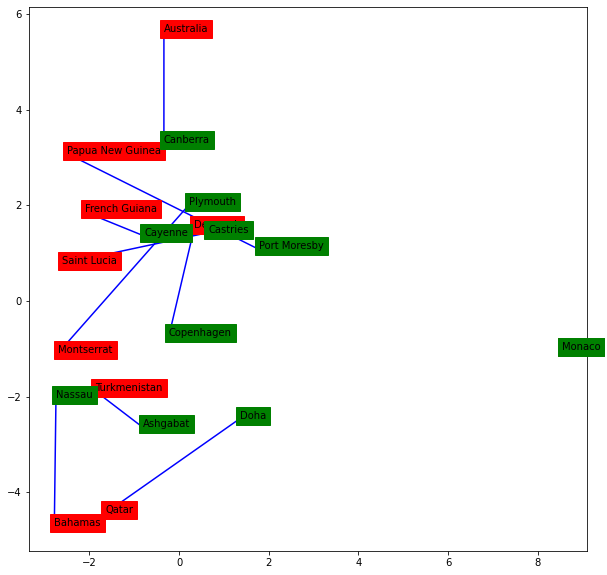

In [31]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

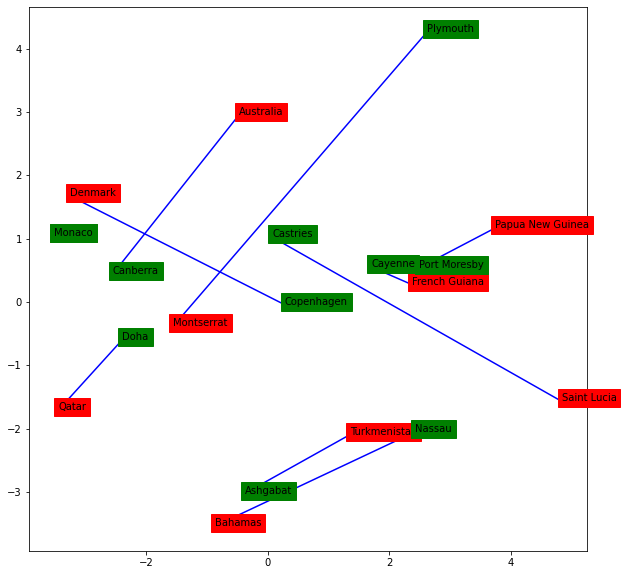

In [32]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [33]:
random_indices = random.sample(range(len(countries)), 10)

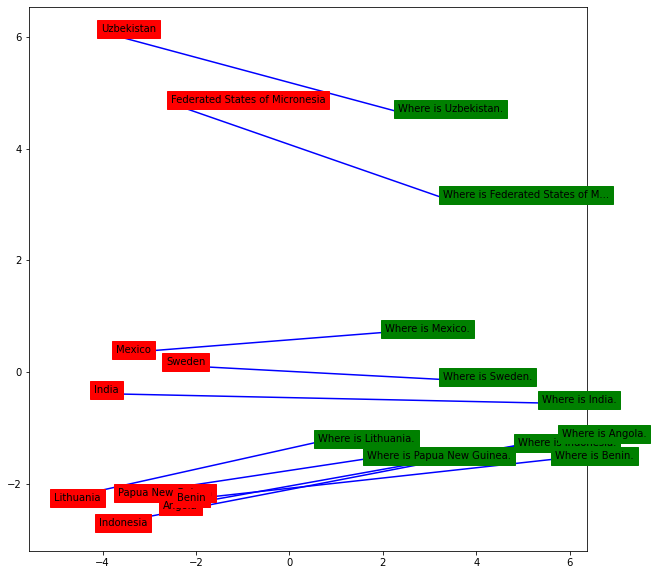

In [34]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

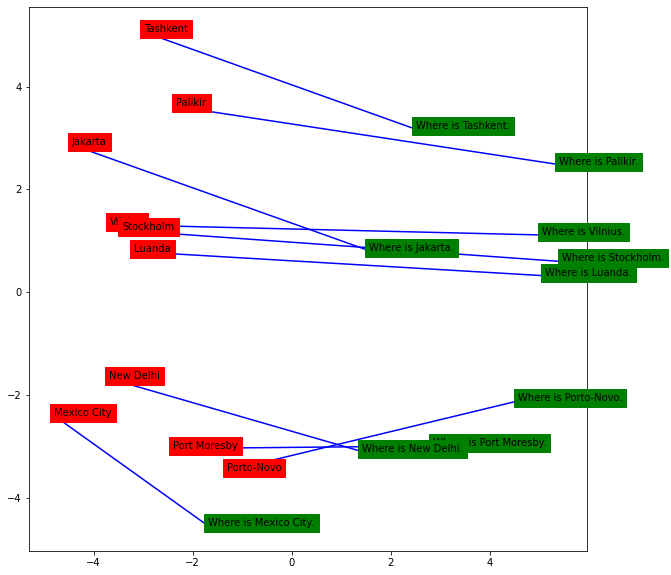

In [35]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

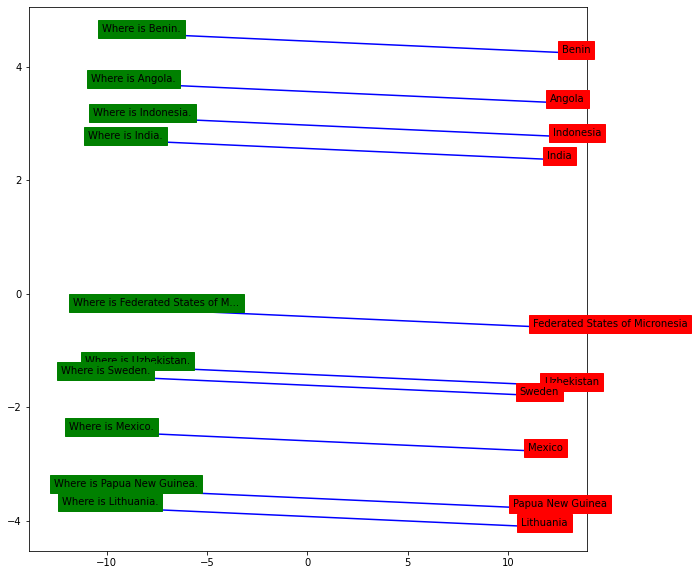

In [36]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

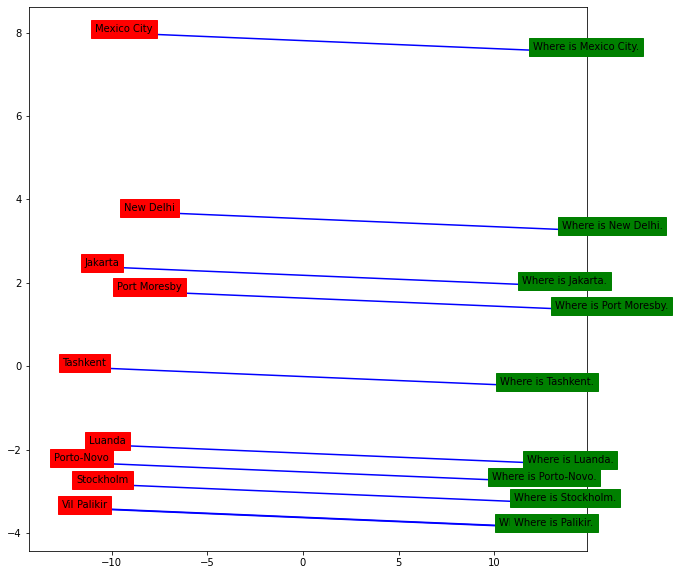

In [37]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

# Test on Countries and Capitals data (Embeddings using randomly chosen sentence context and randomly chosen replacement with general word)

In [38]:
random_sentences = [
    'Where is __REPL__?',
    'How much is the population of __REPL__?',
    'Can you show me __REPL__ on map ?',
    'How many people are living in __REPL__?',
    '__REPL__ is very beautiful place.',
    'How many tourists are in __REPL__.',
    'There are many beautiful parks in __REPL__.',
    '__REPL__ is the best place to eat great food.',
    '__REPL__ is the most popular tourist destination?'
]

In [39]:
REPL = '__REPL__'

In [40]:
def sample(items):
    return random.sample(items, 1)[0]

## Get Embeddings

In [41]:
country_sents = [sample(random_sentences).replace(REPL, item) for item in countries]
country_sents.extend([sent.replace(item, '') for sent, item in zip(country_sents, countries)])

capital_sents = [sample(random_sentences).replace(REPL, item) for item in capitals + ['']]
capital_sents.extend([sent.replace(item, '') for sent, item in zip(capital_sents, capitals)])

In [42]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [43]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [44]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[len(countries)+i]) 
                     for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[len(capitals)+i]) 
                     for i in range(len(capitals))]

## Embeddings of Words (only)

### Show Original Embeddings

In [45]:
random_indices = random.sample(range(len(countries)), 10)

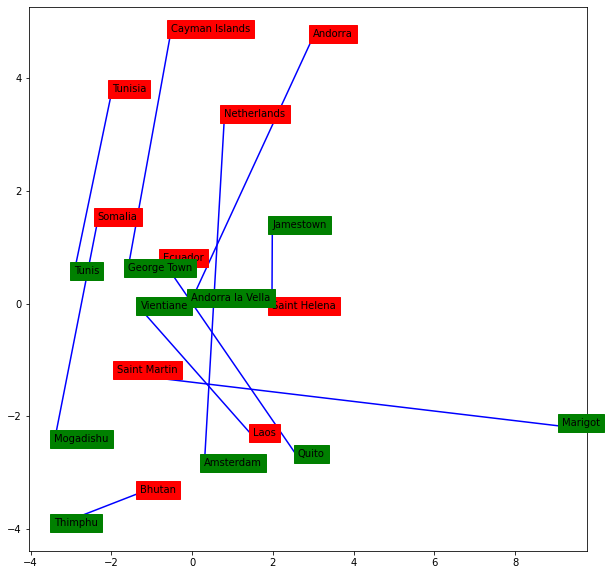

In [46]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

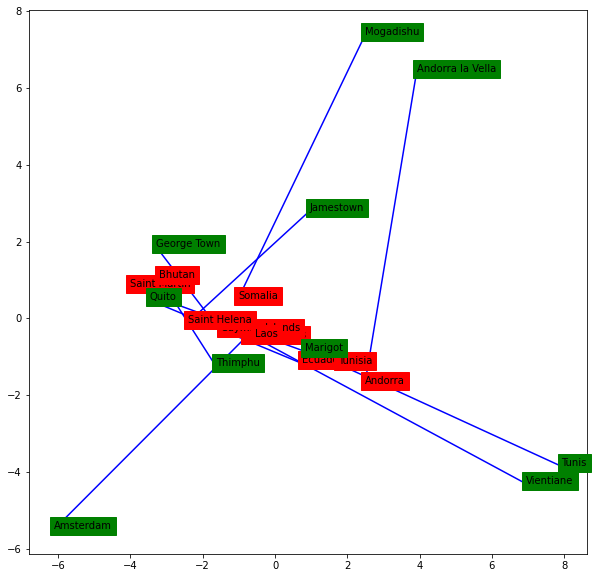

In [47]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [48]:
random_indices = random.sample(range(len(countries)), 10)

#### Countries

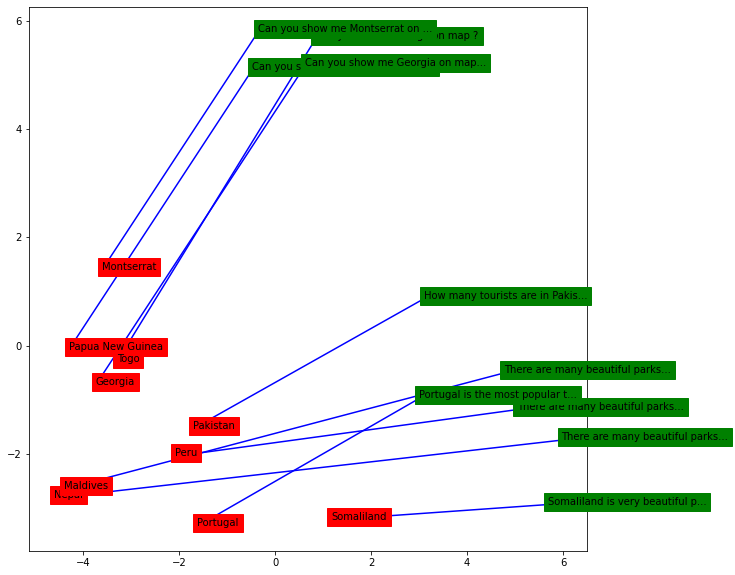

In [49]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### capitals

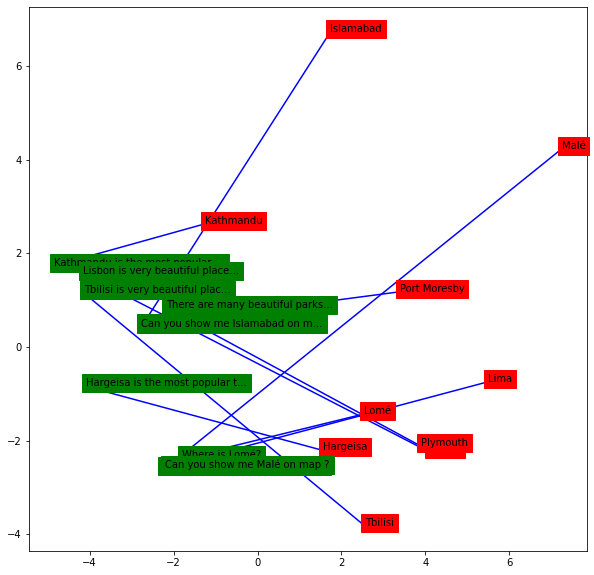

In [50]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

#### Countries

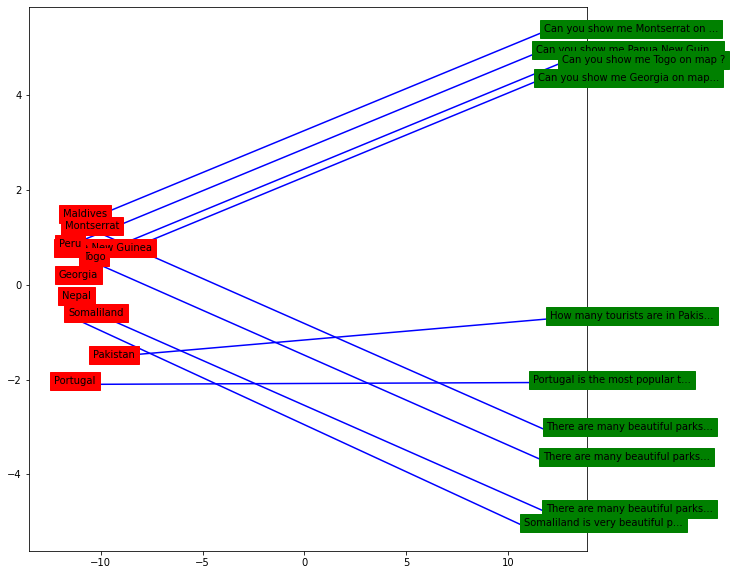

In [51]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### Capitals

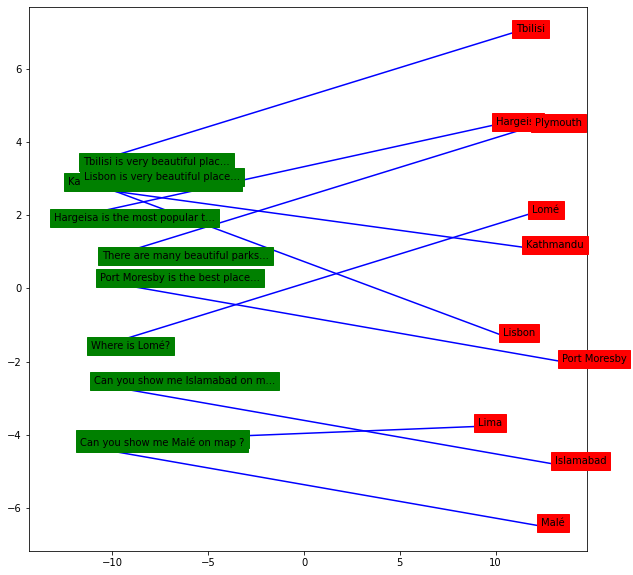

In [52]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

# Test on Countries and Capitals data (Embeddings using randomly chosen document context (multiple occurrences) and randomly chosen replacement with general word)

In [53]:
random_documents = [
    'Where is __REPL__? Many people know things about __REPL__. Many people know about __REPL__ and it is regarded to one of the most wanted and popular for people',
    'How much is the population of __REPL__? Last year there was a huge economical crisis which caused many problems and hence decreased the population. Immigration problems in __REPL__ were started recently which caused additional economical weakness.',
    'Can you show me __REPL__ on map ? I was looking for that yesterday but I did not find __REPL__. Maybe I am using an outdated map which does not allow me to do right query.',
    'How many people are living in __REPL__?',
    '__REPL__ is very beautiful place.',
    'How many tourists are in __REPL__. Previously it was regarded as the best tourist destination. That fact increased number of tourists and had positive impact on __REPL__\'s economy. It opened various jobs for local people actually in tourism.',
    'There are many beautiful parks in __REPL__.',
    '__REPL__ is the best place to eat great food.',
    '__REPL__ is the most popular tourist destination?'
]

In [54]:
REPL = '__REPL__'

In [55]:
def sample(items):
    return random.sample(items, 1)[0]

## Get Embeddings

In [56]:
country_sents = [sample(random_documents).replace(REPL, item) for item in countries]
country_sents.extend([sent.replace(item, '') for sent, item in zip(country_sents, countries)])

capital_sents = [sample(random_documents).replace(REPL, item) for item in capitals + ['']]
capital_sents.extend([sent.replace(item, '') for sent, item in zip(capital_sents, capitals)])

In [57]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [58]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [59]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[len(countries)+i]) 
                     for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[len(capitals)+i]) 
                     for i in range(len(capitals))]

## Embeddings of Words (only)

### Show Original Embeddings

In [60]:
random_indices = random.sample(range(len(countries)), 10)

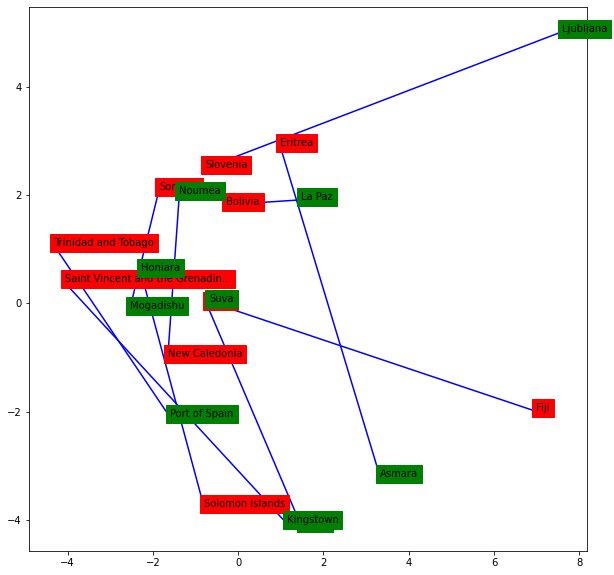

In [61]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

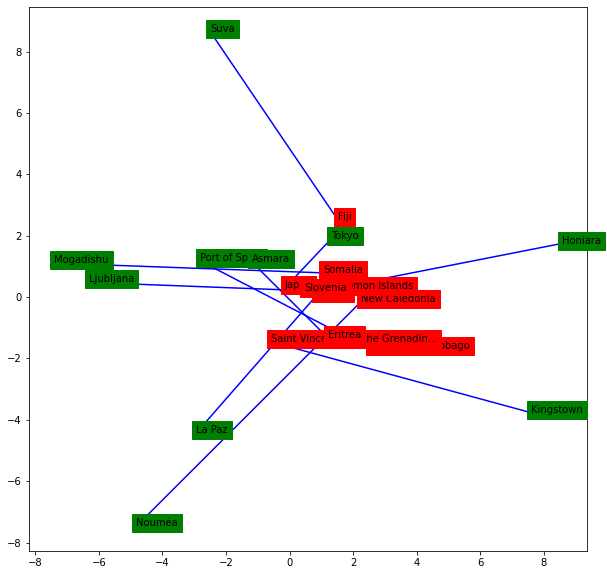

In [62]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [63]:
random_indices = random.sample(range(len(countries)), 10)

#### Countries

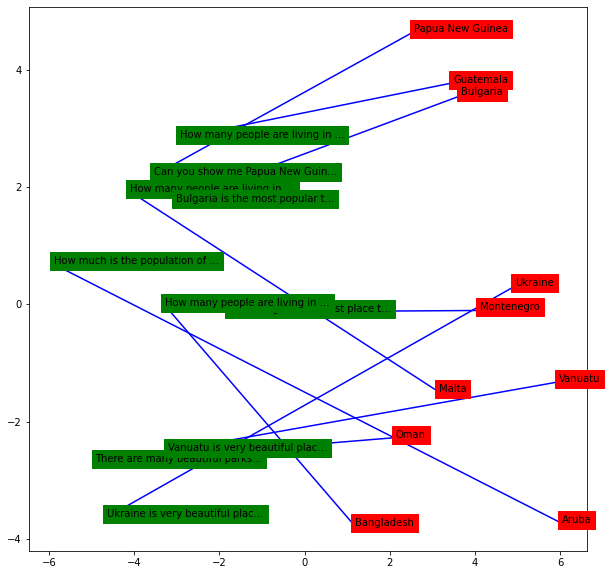

In [64]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### capitals

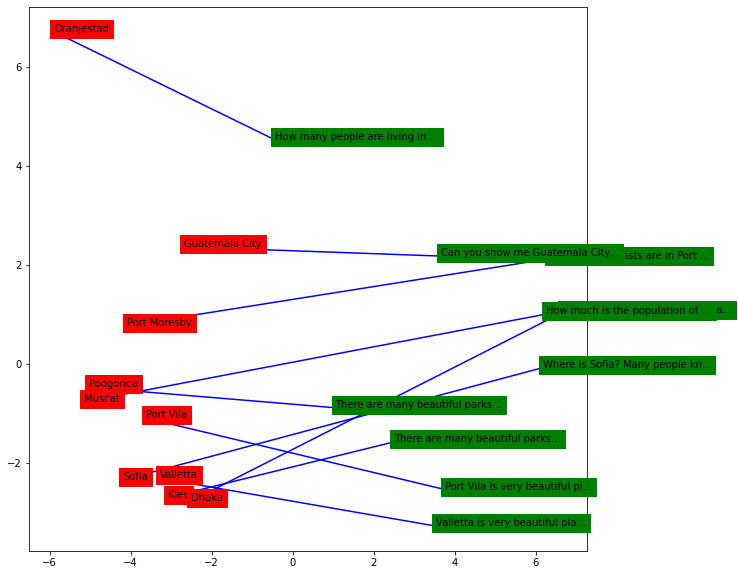

In [65]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

#### Countries

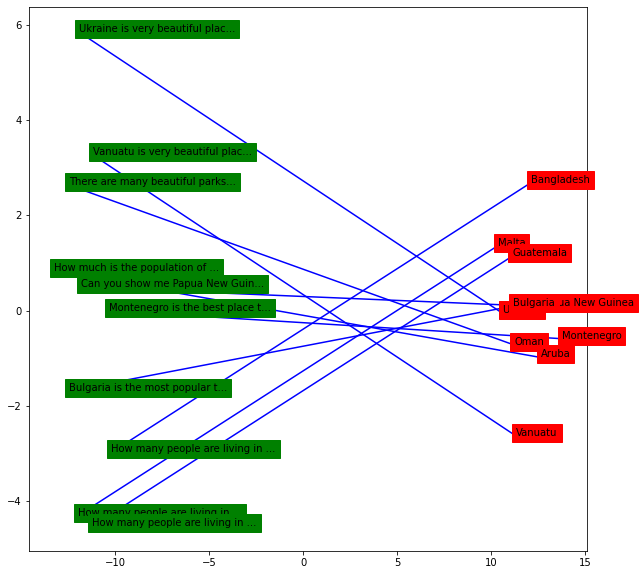

In [66]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### Capitals

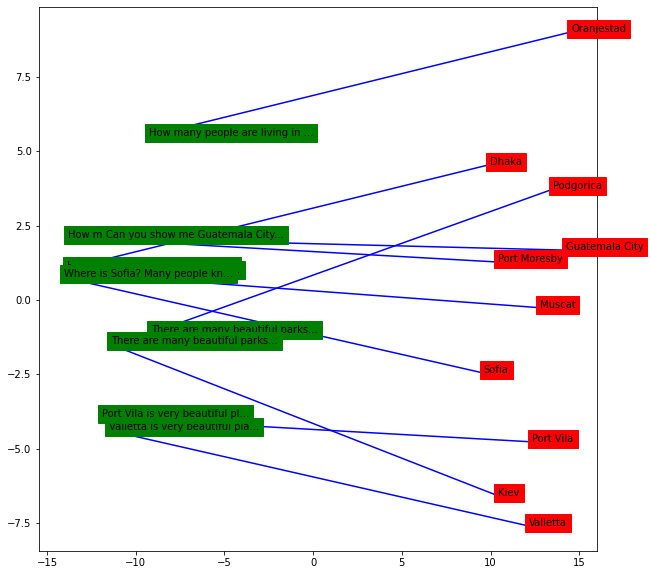

In [67]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

# Test on Countries and Capitals data (Embeddings using randomly chosen document context (multiple occurrences) but averaging of sentence and token embeddings

In [68]:
# !bert-serving-start -num_worker=1 -max_seq_len=None-model_dir ./cased_L-12_H-768_A-12 -pooling_strategy NONE -pooling_layer -2 -show_tokens_to_client

In [69]:
bc = BertClient(output_fmt='ndarray')

In [70]:
random_documents = [
    'Where is __REPL__? Many people know things about __REPL__. Many people know about __REPL__ and it is regarded to one of the most wanted and popular for people',
    'How much is the population of __REPL__? Last year there was a huge economical crisis which caused many problems and hence decreased the population. Immigration problems in __REPL__ were started recently which caused additional economical weakness.',
    'Can you show me __REPL__ on map ? I was looking for that yesterday but I did not find __REPL__. Maybe I am using an outdated map which does not allow me to do right query.',
    'How many people are living in __REPL__?',
    '__REPL__ is very beautiful place.',
    'How many tourists are in __REPL__. Previously it was regarded as the best tourist destination. That fact increased number of tourists and had positive impact on __REPL__\'s economy. It opened various jobs for local people actually in tourism.',
    'There are many beautiful parks in __REPL__.',
    '__REPL__ is the best place to eat great food.',
    '__REPL__ is the most popular tourist destination?'
]

In [71]:
REPL = '__REPL__'

In [72]:
def sample(items):
    return random.sample(items, 1)[0]

## Get Embeddings

In [73]:
country_sents = [sample(random_documents).replace(REPL, item) for item in countries]

capital_sents = [sample(random_documents).replace(REPL, item) for item in capitals]

In [74]:
country_sent_token_embs, country_sent_tokens = bc.encode(country_sents, show_tokens=True)
capital_sent_token_embs, capital_sent_tokens = bc.encode(capital_sents, show_tokens=True)

/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [75]:
def reduce_mean(token_embs, tokens):
    return token_embs[1:len(tokens)-1].mean(axis=0)

In [76]:
country_sent_embs = [reduce_mean(sent_token_embs, sent_tokens) for sent_token_embs, sent_tokens in 
                     zip(country_sent_token_embs, country_sent_tokens)]

In [77]:
capital_sent_embs = [reduce_mean(sent_token_embs, sent_tokens) for sent_token_embs, sent_tokens in 
                     zip(capital_sent_token_embs, country_sent_tokens)]

Use previous embeddings with (`-pooling_strategy=REDUCE_MEAN` and `-pooling_layer=-2`)

In [78]:
# country_embs = bc.encode(countries)
# capital_embs = bc.encode(capitals)

In [129]:
import unidecode

In [79]:
import re

In [80]:
def filter_token(token):
    return re.sub(r'[#| ]', '', token)

In [81]:
def merge_tokens(sent_tokens):
    text = ''
    indices = []
    for idx, token in enumerate(sent_tokens):
        if token not in ['[CLS]', '[SEP]']:
            filtered_token = filter_token(token)
            text += filtered_token
            indices += [idx]*len(filtered_token)
    
    return text, indices

In [135]:
def get_all_unique_matching_indices(query, text, indices):
    unique_matching_indices = set()
    for match in re.finditer(re.escape(query), text):
        unique_matching_indices.update(indices[match.start():match.end()])
        
    if not unique_matching_indices:
        print(f'NO MATCH!  {query}:{text}')

    return unique_matching_indices

In [136]:
def get_token_indices(phrase, sent_tokens):
    sent_text, sent_indices = merge_tokens(sent_tokens)
    phrase_text = unidecode.unidecode_expect_nonascii(filter_token(phrase))
    match_indices = get_all_unique_matching_indices(phrase_text, sent_text, sent_indices)
    
    return list(match_indices)

In [137]:
def get_phrase_embedding(phrase, sent_token_embs, sent_tokens):
    token_indices = get_token_indices(phrase, sent_tokens)
#     if len(token_indices) == 0:
#         print(f'{phrase}{sent_tokens}')
    phrase_emb = sent_token_embs[token_indices,:].mean(axis=0).tolist()
    
    return phrase_emb

In [138]:
subs_country_embs = [get_phrase_embedding(country.lower(), sent_token_emb, sent_tokens) for 
               country, sent_token_emb, sent_tokens in zip(countries, country_sent_token_embs, country_sent_tokens)]

subs_capital_embs = [get_phrase_embedding(capital.lower(), sent_token_emb, sent_tokens) for 
               capital, sent_token_emb, sent_tokens in zip(capitals, capital_sent_token_embs, capital_sent_tokens)]

NO MATCH!  nuku`alofa:nukuʻalofaisverybeautifulplace.


/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice.
/home/ubuntu/anaconda3/envs/ke/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


## Embeddings of Words (only)

### Show Original Embeddings

In [139]:
random_indices = random.sample(range(len(countries)), 10)

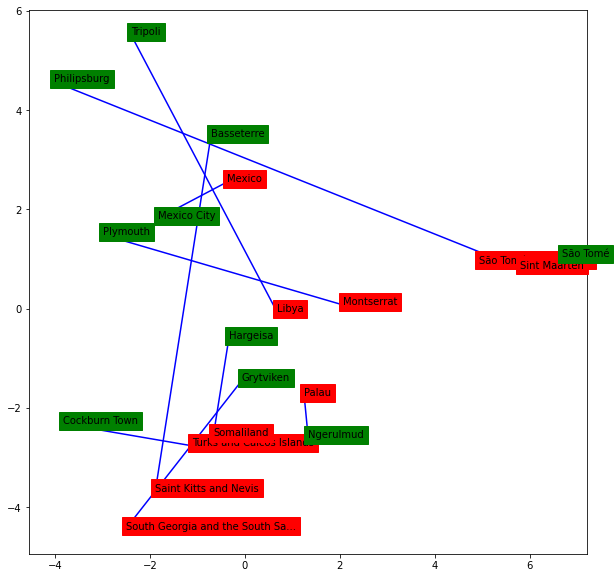

In [140]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

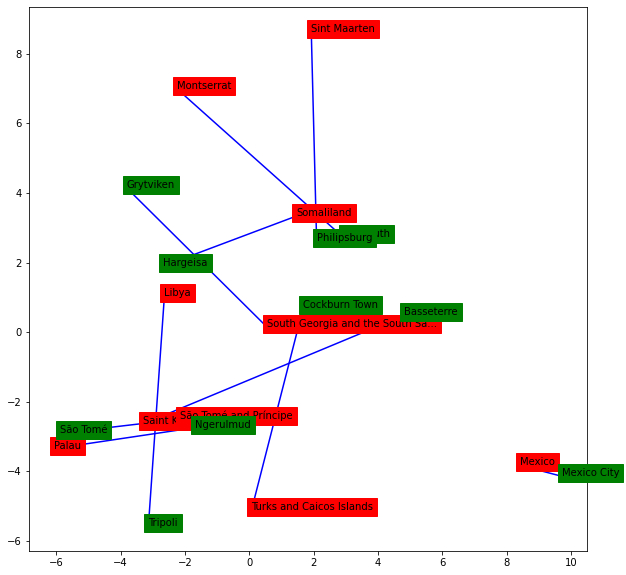

In [141]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [142]:
random_indices = random.sample(range(len(countries)), 10)

#### Countries

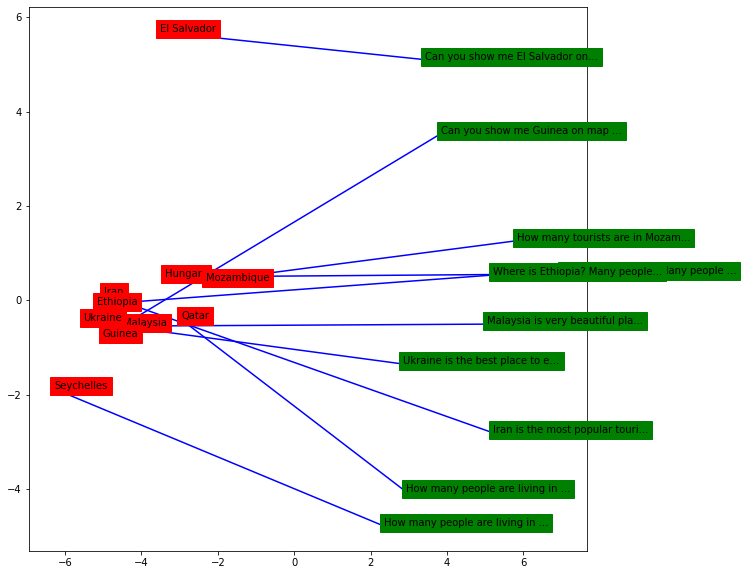

In [143]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### capitals

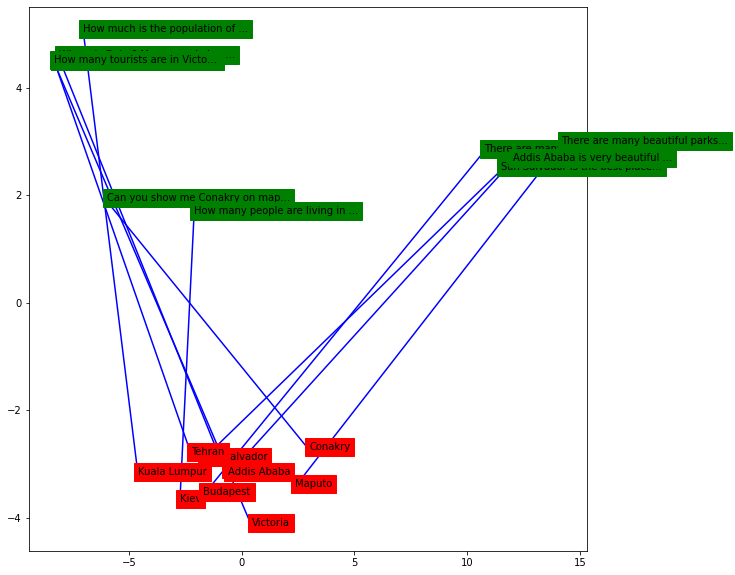

In [144]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

#### Countries

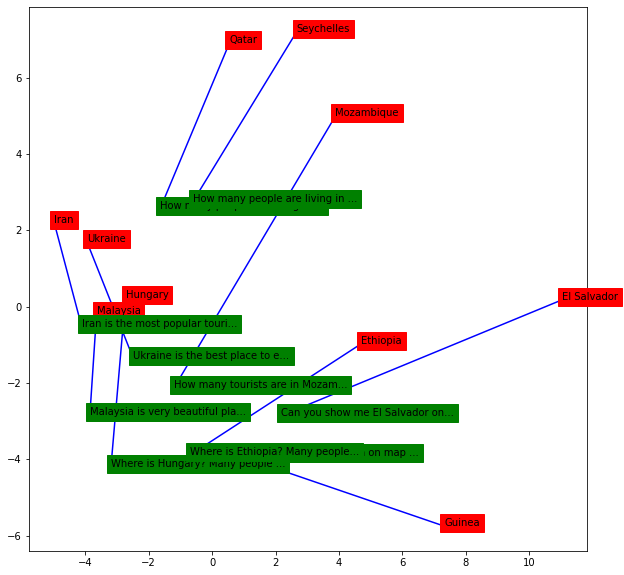

In [145]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### Capitals

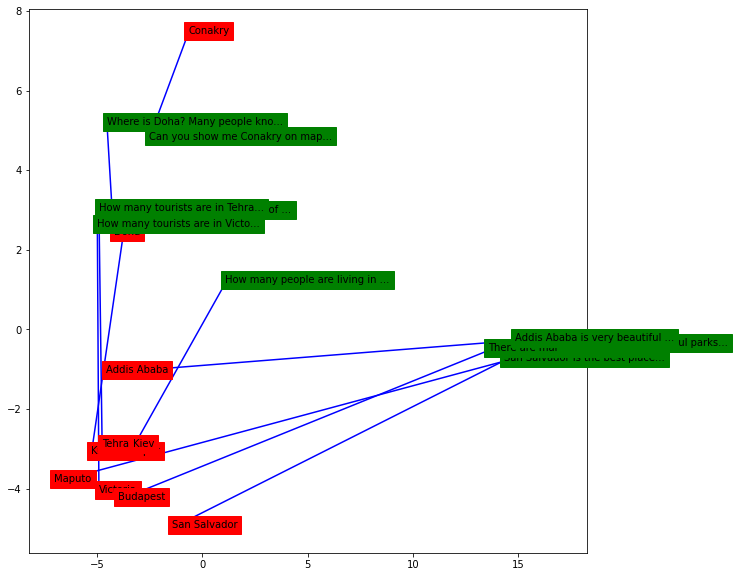

In [146]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))